# Brain Image Segmentation

## Download Materials

We use the simulated [BrainWeb](https://brainweb.bic.mni.mcgill.ca/brainweb) dataset from McGill University for this homework. First, we can download and unzip the data by executing the following commands.

In [ ]:
!wget -nc https://courses.cs.washington.edu/courses/cse577/17au/assignments/hw2.zip

!unzip -o hw2.zip

--2021-11-03 02:41:10--  https://courses.cs.washington.edu/courses/cse577/17au/assignments/hw2.zip
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64945 (63K) [application/zip]
Saving to: ‘hw2.zip’

hw2.zip             100%[===================>]  63.42K   224KB/s    in 0.3s    

2021-11-03 02:41:11 (224 KB/s) - ‘hw2.zip’ saved [64945/64945]

Archive:  hw2.zip
   creating: test/
  inflating: test/3.mat              
  inflating: test/1.jpg              
  inflating: test/2.mat              
  inflating: test/2.jpg              
  inflating: test/1.mat              
  inflating: test/3.jpg              
   creating: train/
  inflating: train/3.mat             
  inflating: train/1.jpg             
  inflating: train/2.mat             
  inflating: train/2.jpg             
  inflat

## Contents

|Sample brain MRI image   | Segmented image  |
|---|---|
| <img src="https://courses.cs.washington.edu/courses/cse577/21au/assignments/image.png"> | <img src="https://courses.cs.washington.edu/courses/cse577/21au/assignments/label.png"> | 



Brain MRI analysis is an essential task in many clinical applications. Fundamental components of structural brain MRI analysis include the classification of MRI data into specifict tissue types and the identification and description of specific anotomical structures. Among all the tissue types, the tissue elements we are typically interested in are: cerebrospinal fluid (CSF), gray matter (GM) and white matter (WM); see Figure b). The segmentation results are further used in different applications such as for analyzing anatomical structures, for studying pathological regions, for surgical planning, and for visualization purposes.

Brain image segmentation can be performed on 2D images, sequences of 2D images, or 3D volumetric images. There are several techniques to achieve the segmentation. They can be classfied into thresholding methods [1, 2, 3], clustering methods [4, 5, 6], edge detection methods [7, 8, 9], region-based methods [10, 11], model-based methods [12, 13, 14] and Hidden Markov Random Field methods [15, 16, 17].

Here we will try some basic 2D thresholding and clustering method to find the 3 interesting regions in the testing brain MRI images given 3 training images with their groundtruth labels. The MRI images and their corresponding labels are from the normal anatomical models simulated from BrainWeb (T1-weighted).


In [ ]:
#@title Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import skimage
import skimage.morphology  # For helper morphology functions
import cv2  # open cv
from sklearn.cluster import KMeans

import random
import imageio
import glob
import os


In the following visualization, we show the three images in the training set and the three images in the testing set. 

The first row is the input image, and the second row is the ground truth label.

In the labels:
- Class 0. Background: dark blue
- Class 1. CSF: dark green
- Class 2. GM: light green
- Class 3. WM: yellow

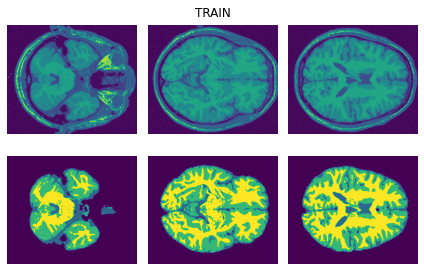

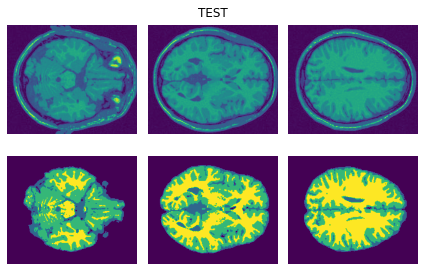

In [ ]:
#@title Load Training Data
trainImages = []
trainLabels = []

for dirname in ["train", "test"]:
  for i, filename in enumerate(glob.glob(os.path.join(dirname, "*.jpg"))):
    img = imageio.imread(filename)
    trainImages.append(img)
    label = scipy.io.loadmat(filename.replace(".jpg", ".mat"))["label"]
    trainLabels.append(label)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.subplot(2, 3, i + 1 + 3)
    plt.imshow(label)
    plt.axis("off")
  plt.suptitle(dirname.upper())
  plt.tight_layout()
  plt.show()


trainImages = np.concatenate(trainImages, axis=0).reshape(-1)
trainLabels = np.concatenate(trainLabels, axis=0).reshape(-1)

We can calculate the mean color for each tissue types.

We use class 0 to represent the background, 1 for CSF, 2 for GM, and 3 for WM.

In [ ]:
#@title Compute Training Features

# Here we calculate the mean CSF/GM/WM values for reference later.
meanCSF = np.mean(trainImages[trainLabels==1])
meanGM = np.mean(trainImages[trainLabels==2])
meanWM = np.mean(trainImages[trainLabels==3])

print("Mean Value of:\n\tCSF Color: %d\n\tGM Color: %d\n\tWM Color: %d" % (
    meanCSF, meanGM, meanWM))

Mean Value of:
	CSF Color: 65
	GM Color: 112
	WM Color: 139


## K-Means Method

By observing the training and testing images, you might notice that besides the inner brain region, there are some outer non-brain regions such as skulls. It's hard to differentiate them from the inner brain region using only pixel intensities. First, we remove the outer region using image morphology.

In [ ]:
#@title Remove Out Brain


def remove_out_brain(img, bg_color=160, dilation_radius=23, erosion_radius=15):
  """Remove the outer brain region.
  
  Args:
    img (np.array): a [height, width] uint8 image.

  Returns:
    img (np.array): an image without the outer brain region.
  """

  mask = img > bg_color  # create a binary image

  # Perform morphology
  mask = skimage.morphology.dilation(mask, 
                                     skimage.morphology.disk(dilation_radius))
  mask = skimage.morphology.erosion(mask, 
                                    skimage.morphology.disk(erosion_radius))
  mask = 1 - mask

  # Get the largest region in the mask
  n, connected_components = cv2.connectedComponents(mask.astype(np.uint8))
  (unique, counts) = np.unique(connected_components, return_counts=True)
  max_cls = np.argmax(counts[1:]) + 1
  mask_single = connected_components == max_cls

  return img * mask_single



In [ ]:
#@title Apply K-Means
def apply_k_means(img, num_clusters):
  """Apply K-means model on the image.

  Args:
    img (np.array): input image with [height, width] shape.
    num_clusters (int): number of clusters for the k-means algorithm.

  Returns:
    components (np.array): an output with [height, width] shape, where each
      pixel is a cluster ID.
  """
  
  kmeans = KMeans(n_clusters=num_clusters, random_state=1).fit_predict(img.reshape(-1,1))          
  
  #labels = kmeans.labels_
  #predict = kmeans.predict
  #return kmeans(shape=img.shape)
  #return np.zeros(shape=img.shape)

  kmeans = np.reshape(kmeans,(181,217))
  return kmeans
  

In [ ]:
#@title Assign Class for K-Means
def assign_class(img, k_means_img):
  """Get tissue class from the image and the k-means class.

  Args:
    img (np.array): input image with [height, width] shape.
    k_means_img (np.array): an image with [height, width] shape, calcualted
      from the `apply_k_means` function.

  Returns:
    class_img (np.array): an output with [height, width] shape, where each
      pixel is a class ID. 0: background, 1: CSF; 2: GM; 3: WM.
  """

  for ir, row in enumerate(k_means_img):
    for ic, col in enumerate(row):
        if col == 0:
            k_means_img[ir][ic]= 0
        elif col == 1:
            k_means_img[ir][ic]=2
        elif col == 2:
            k_means_img[ir][ic]=1
        elif col == 3:
            k_means_img[ir][ic]=3
  class_img = k_means_img
  
  
  #return np.zeros(shape=img.shape)
  return class_img

In [ ]:
#@title Process
def process(image_id, bg_color, dilation_radius, erosion_radius):
  """Process one image from the testing set.

  Args:
    image_id (int): a value of 1, 2, or 3, for the test image.
    bg_color (int): a value to create binary mask.
    dilation_radius (int): for mathematical morphology.
    erosion_radius (int): for mathematical morphology.
  """
  assert image_id in [1, 2, 3]
  plt.figure(figsize=(16, 4)) 

  label = scipy.io.loadmat("test/%d.mat" % image_id)["label"]

  img = imageio.imread("test/%d.jpg" % image_id)

  img2 = remove_out_brain(img, bg_color, dilation_radius, erosion_radius)

  plt.subplot(1, 7, 1)
  plt.imshow(img)
  plt.title("Image")
  plt.axis("off")

  plt.subplot(1, 7, 2)
  plt.imshow(label)
  plt.title("Label")
  plt.axis("off")

  plt.subplot(1, 7, 3)
  plt.imshow(img2)
  plt.title("Remove Out Brain")
  plt.axis("off")

  plt.subplot(1, 7, 4)
  img3 = apply_k_means(img2, 4)
  plt.imshow(img3, cmap="nipy_spectral")
  plt.title("K-means")
  plt.axis("off")


  plt.subplot(1, 7, 5)
  pred = assign_class(img2, img3)
  plt.imshow(pred)
  plt.title("Prediction")
  plt.axis("off")


  plt.subplot(1, 7, 6)
  diff = np.abs(pred - label) > 0
  plt.imshow(diff)
  plt.title("Diff")
  plt.axis("off")


  plt.suptitle("Image %d: The pixel-wise 4-way segmentation accuracy"
  " is: %.2f%%" % (image_id,      
      np.sum(pred == label) / np.prod(label.shape) * 100),
      y=0
  )

  plt.tight_layout()
  plt.show()

### Try different thresholds

We used some random thresholds below


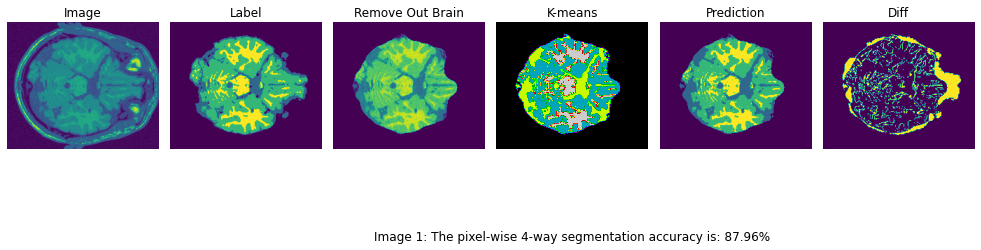

In [ ]:
#@title Test Image 1
process(1, 159, 26, 11)

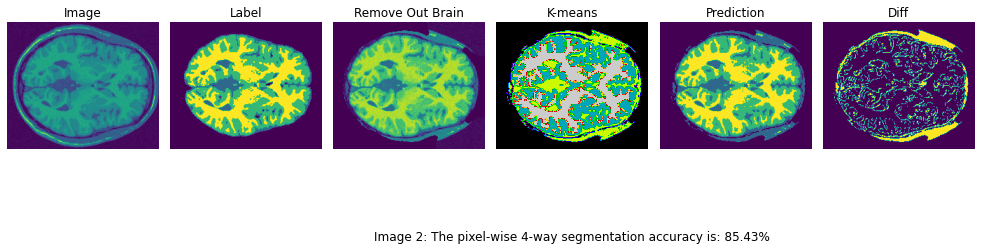

In [ ]:
#@title Test Image 2
process(2, 165, 31, 27)

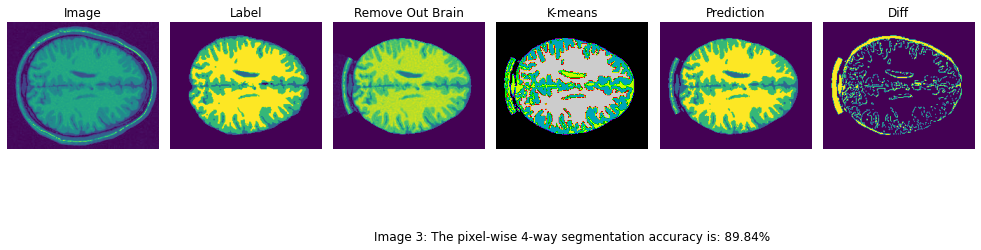

In [ ]:
#@title Test Image 3
process(3, 162, 55, 45)

## U-Net implementation


Here, we will try a deep learning segmentation model [U-Net](https://arxiv.org/abs/1505.04597) to segment the brain images.

If you want to try this method, change the `U_NET` flag to `True`-


In [ ]:
# Turn this flag to True if you want to try U-Net:

U_NET =  True#@param

In [ ]:

if not U_NET:
  raise NotImplementedError

In [ ]:
#@title Import PyTorch and other libraries
import torch  # PyTorch
import torchvision  # modules for vision
import tqdm  # progress bar

In [ ]:
#@title Download and Unzip the data [103 MB]
%%capture
!wget -nc https://courses.cs.washington.edu/courses/cse577/17au/assignments/data.zip
!unzip data.zip

In [ ]:
#@title Load all train data
mat_data = [scipy.io.loadmat(mat_name) for mat_name in glob.glob("sub*.mat")]


You will find that there are 19 subjects in the training set, and each file contains a 3D volume for the MRI and a 3D label for tissue types. Of course, you can use code from the previous homework to visualize the MRI image in 3D space. Here, we just visualize each slice individually for simplicity, because the testing set only contains 2D rather than 3D images.

Wait!... Only 19 subjects...
Are 19 subjects enough to train a deep learning model?... I've heard that deep learning requires lots of data.

Well, even if we only have 19 subjects, there are 181 2D slices for each subject. So, this ends up with  19 * 181 = 3439 grayscale 2D images. Even if data diversity is still limited in the training set, our testing set is not too complex either.

Let's figure it out below.


Here, let's view 20 slices of images from the first subject. So, we have some ideas how the data look like.


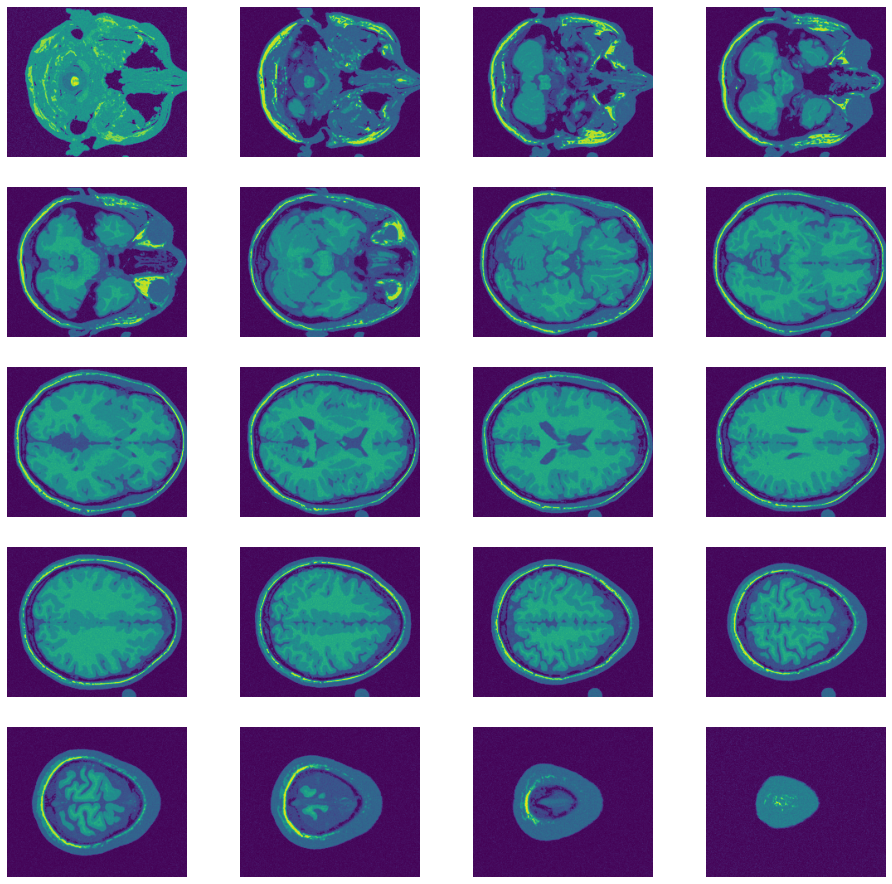

In [ ]:
#@title View data from a subject

print("Here, let's view 20 slices of images from the first subject.",
      "So, we have some ideas how the data look like.")

n_plot = 20  # number of slices to plot for this subject
w = int(np.sqrt(n_plot))  # number of columns for visualization
h = int(np.ceil(n_plot / w))  # number of rows for visualization

plt.figure(figsize=(16, 16))  # Create a large square canvas for plotting

for i in range(n_plot):
  img = mat_data[0]["images"][:, :, int(181 / n_plot * i)]

  plt.subplot(h, w, i + 1)
  plt.imshow(img)
  plt.axis("off")

plt.show()


In [ ]:
#@title Create Tensors
images_list = [d["images"] for d in mat_data]
labels_list = [d["labels"] for d in mat_data]

# Shape is (data_size, height, width)
images = torch.tensor(np.concatenate(images_list, axis=2).swapaxes(0, 2))
labels = torch.tensor(np.concatenate(labels_list, axis=2).swapaxes(0, 2))

# Add Channel as a dimension
images = images.unsqueeze(dim=1)  # Shape is (data_size, 1, height, width)

# Resize images and labels s.t. width and height are multipliers of 32.
# It is a requirement for U-Net and other autoencoder models (with residuals).
transform = torchvision.transforms.Resize(
    [192, 160], interpolation=torchvision.transforms.InterpolationMode.NEAREST)

images = transform(images)
labels  = transform(labels)

print("Images:", images.shape)
print("Labels:", labels.shape)

# Create Data Set
dataset = torch.utils.data.TensorDataset(images, labels)

Images: torch.Size([3439, 1, 192, 160])
Labels: torch.Size([3439, 192, 160])


In [ ]:
#@title Create data loader

# Create a data loader with batch size 8 and shuffling.
# Note 1: check `torch.utils.data.dataloader` .
# Note 2: You will need the `dataset` variable from the above block.
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
#@title Create U-Net Model

# Set random seed for reproduciablity
torch.manual_seed(577)
random.seed(577)

# The `init_features` defines how many channels the hidden layers contain.
# Usually, people would use 32 init features. Here, because our dataset
# is small, we use 4 init feautures. So, the channel size is about 32 / 4 = 8
# times smaller, and the training speed is about 8 x 8 = 64 times faster.
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=1, out_channels=4, init_features=4, pretrained=False)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [ ]:
#@title Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()


In [ ]:
#@title Create an optimizer


# Creating an Adam optimizer with learning rate 0.001.
# Paper Reference: https://arxiv.org/abs/1412.6980
# Note: check out `torch.optim.Adam`
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)  

In [ ]:
#@title Training
# For simplicity, we only train a few epochs. Good enough~
# Note that you might need 20 minutes to run this block.

# If you have enough time (or machine power), you can increase 
# the number of epochs. It can improve your results.
# Don't turn off your monitor while running the code: if the 
# machine falls asleep, the Colab will stop working.
num_epochs = 5


use_cuda = torch.cuda.is_available()
if use_cuda:
  model = model.cuda()

for epoch in range(num_epochs):
  losses = []
  if dataloader is None or optimizer is None:
    break  # NotImplementedError
  for x, y in tqdm.tqdm(dataloader):
    if use_cuda:
      x, y = x.cuda(), y.cuda()
    pred = model(x.float())
    loss = criterion(pred, y.long())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    losses.append(loss.item())

  print("Epoch:", epoch, "Mean Loss:", np.mean(losses))

100%|██████████| 430/430 [02:30<00:00,  2.86it/s]


Epoch: 0 Mean Loss: 1.1758259313051092


100%|██████████| 430/430 [02:26<00:00,  2.93it/s]


Epoch: 1 Mean Loss: 0.9141886798448341


100%|██████████| 430/430 [02:30<00:00,  2.86it/s]


Epoch: 2 Mean Loss: 0.8251794602981833


100%|██████████| 430/430 [02:27<00:00,  2.91it/s]


Epoch: 3 Mean Loss: 0.7941695175891699


100%|██████████| 430/430 [02:28<00:00,  2.90it/s]

Epoch: 4 Mean Loss: 0.7808383251345434


In [ ]:
#@title Evaluation
def evaluate(image_id, model):
  assert image_id in [1, 2, 3]
  plt.figure(figsize=(15, 4)) 

  label = scipy.io.loadmat("test/%d.mat" % image_id)["label"]

  img = imageio.imread("test/%d.jpg" % image_id)
  
  h, w = img.shape
  plt.subplot(1, 4, 1)
  plt.imshow(img)
  plt.title("Image")
  plt.axis("off")

  plt.subplot(1, 4, 2)
  plt.imshow(label)
  plt.title("Label")
  plt.axis("off")

  plt.subplot(1, 4, 3)


  # Create and Reshape Tensor
  tensor = torch.tensor(img).swapaxes(0, 1).unsqueeze(0).unsqueeze(0)  # cast
  tensor = transform(tensor)
  if use_cuda:
    tensor = tensor.cuda()

  # Make Prediction and Reshape Back
  pred = model(tensor.float())
  pred = pred[0, :, :]  # remove the batch dimension
  prob_max, pred = pred.max(dim=0)
  pred = pred.swapaxes(0, 1)  # switch to (height, width)
  pred = pred.detach().cpu().numpy()  # cast to numpy
  pred = cv2.resize(pred, (w, h), interpolation = cv2.INTER_NEAREST)

  plt.imshow(pred)
  plt.title("Pred")
  plt.axis("off")

  plt.subplot(1, 4, 4)
  diff = np.abs(pred - label) > 0
  plt.imshow(diff)
  plt.title("Diff")
  plt.axis("off")


  plt.suptitle("Image %d: The pixel-wise 4-way segmentation accuracy"
  " is: %.2f%%" % (image_id,      
      np.sum(pred == label) / np.prod(label.shape) * 100),
  y=0)

  plt.tight_layout()
  plt.show()



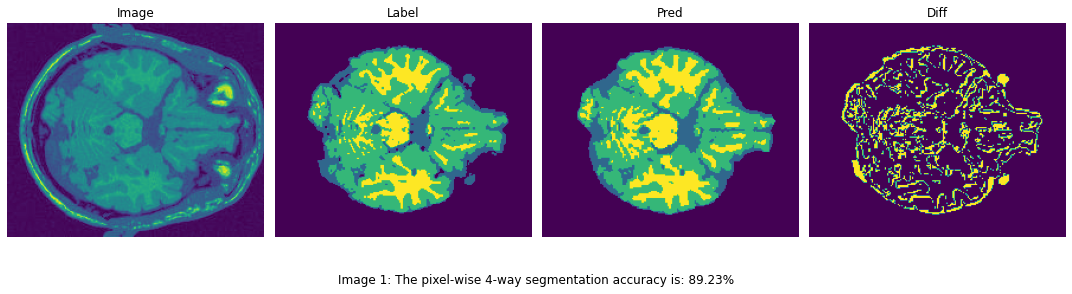

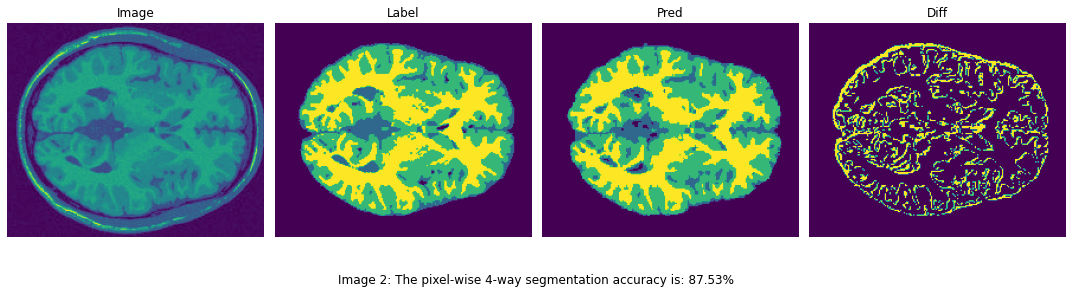

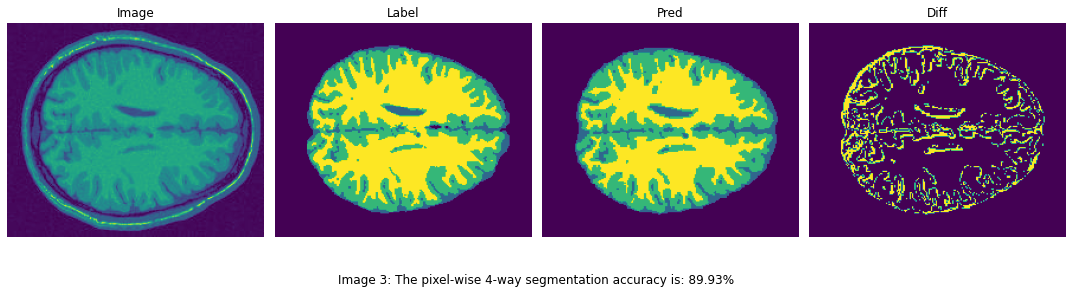

In [ ]:
#@title Run Evaluation
evaluate(1, model)
evaluate(2, model)
evaluate(3, model)

## References

[1] Kumar, S., et al.: Skull stripping and automatic segmentation of brain MRI using seed growth and threshold techniques pp. 422-426 (2007)

[2] Natarajan, P., Krishnan, N., Kenkre, N.S., Nancy, S., Singh, B.P.: Tumor detection using threshold operation in MRI brain images pp. 1-4 (2012)

[3] Zhao, M., Lin, H.Y., Yang, C.H., Hsu, C.Y., Pan, J.S., Lin, M.J.: Automatic threshold level set model applied on MRI image segmentation of brain tissue. Appl. Math 9(4), 1971-1980 (2015)

[4] Pham, D.L., Xu, C., Prince, J.L.: Current methods in medical image segmentation 1. Annual review of biomedical engineering 2(1), 315-337 (2000)

[5] Wu, Z., Leahy, R.: An optimal graph theoretic approach to data clustering: Theory and its application to image segmentation. Pattern Analysis and Machine Intelligence, IEEE Transactions on 15(11), 1101-1113 (1993)

[6] Chuang, K.S., Tzeng, H.L., Chen, S., Wu, J., Chen, T.J.: Fuzzy c-means clustering with spatial information for image segmentation. computerized medical imaging and graphics 30(1), 9-15 (2006)

[7] Perona, P., Malik, J.: Scale-space and edge detection using anisotropic diffusion. Pattern Analysis and Machine Intelligence, IEEE Transactions on 12(7), 629-639 (1990)

[8] Senthilkumaran, N., Rajesh, R.: Edge detection techniques for image segmentation-a survey of soft computing approaches. International journal of recent trends in engineering 1(2) (2009)

[9] Canny, J.: A computational approach to edge detection. Pattern Analysis and Machine Intelligence, IEEE Transactions on (6), 679-698 (1986)

[10] Lin, G.C., Wang, W.J., Kang, C.C., Wang, C.M.: Multispectral MR images segmentation based on fuzzy knowledge and modified seeded region growing. Magnetic resonance imaging 30(2), 230-246 (2012)

[11] Roura, E., Oliver, A., Cabezas, M., Vilanova, J.C., Rovira, A., Rami  o-Torrent  a, L., Llad o, X.: Marga: multispectral adaptive region growing algorithm for brain extraction on axial MRI. Computer methods and programs in biomedicine 113(2), 655-673 (2014)

[12] Chan, T.F., Vese, L., et al.: Active contours without edges. Image processing, IEEE transactions on 10(2), 266-277 (2001)

[13] Ho, S., Bullitt, L., Gerig, G.: Level-set evolution with region competition: automatic 3-d segmentation of brain tumors 1, 532-535 (2002)

[14] McInerney, T., Terzopoulos, D.: Deformable models in medical image analysis: a survey. Medical image analysis 1(2), 91-108 (1996)

[15] Held, K., Kops, E.R., Krause, B.J., Wells III, W.M., Kikinis, R., Muller-Gartner, H.W.: Markov random field segmentation of brain MR images. Medical Imaging, IEEE Transactions on 16(6), 878-886 (1997)

[16] Panjwani, D.K., Healey, G.: Markov random field models for unsupervised segmentation of textured color images. Pattern Analysis and Machine Intelligence, IEEE Transactions on 17(10), 939-954 (1995)

[17] Guerrout, E., Ait-Aoudia, S., Michelucci, D., Mahiou, R.: Hidden markov random fields and direct search methods for medical image segmentation. In: Proceedings of the 5th International Conference on Pattern Recognition Applications and Methods. pp. 154-161 (2016)